In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from os import makedirs
from mimic_constants import *
from scipy.stats import f_oneway

mask_type_strs = {'ig': 'Integrated Gradients', 'saliency': 'Saliency'}

In [ ]:
def perform_anova(image_type, suffix, mask_type, label):
    merged_df = get_merged_stats_sample_df(image_type, suffix, mask_type, label, split='test', idp=True)
    image = merged_df.loc[(merged_df['area'] == f'{image_type}')]['mean'].values
    age = merged_df.loc[(merged_df['area'] == 'age_bar')]['mean'].values
    urea = merged_df.loc[(merged_df['area'] == 'urea_bar')]['mean'].values
    chloride = merged_df.loc[(merged_df['area'] == 'chloride_bar')]['mean'].values
    rr = merged_df.loc[(merged_df['area'] == 'rr_bar')]['mean'].values
    magnesium = merged_df.loc[(merged_df['area'] == 'magnesium_bar')]['mean'].values
    glucose = merged_df.loc[(merged_df['area'] == 'glucose_bar')]['mean'].values
    phosphate = merged_df.loc[(merged_df['area'] == 'phosphate_bar')]['mean'].values
    hematocrit = merged_df.loc[(merged_df['area'] == 'hematocrit_bar')]['mean'].values
    
    distributions = [image, age, urea, chloride, rr, magnesium, glucose, phosphate, hematocrit]
    
    f_statistic, p_value = f_oneway(*distributions)

    mask_type_str = mask_type_strs[mask_type]
    
    print(f"{label} {mask_type_str} P-Value: {p_value}")
    print(f"{label} {mask_type_str} F-Statistic: {f_statistic}")
    
    if p_value < 0.05:
        print("There is a significant difference between the distributions.")
    else:
        print("No significant difference between the distributions.")

def get_mean_median(image_type, suffix, mask_type, label):
    merged_df = get_merged_stats_sample_df(image_type, suffix, mask_type, label, split='test', idp=True)
    image_mean   = merged_df.loc[(merged_df['area'] == f'{image_type}')]['mean'].mean()
    image_median = merged_df.loc[(merged_df['area'] == f'{image_type}')]['median'].median()
    age_mean    = merged_df.loc[(merged_df['area'] == 'age_bar')]['mean'].mean()
    urea_mean    = merged_df.loc[(merged_df['area'] == 'urea_bar')]['mean'].mean()
    chloride_mean    = merged_df.loc[(merged_df['area'] == 'chloride_bar')]['mean'].mean()
    rr_mean    = merged_df.loc[(merged_df['area'] == 'rr_bar')]['mean'].mean()
    magnesium_mean    = merged_df.loc[(merged_df['area'] == 'magnesium_bar')]['mean'].mean()
    glucose_mean    = merged_df.loc[(merged_df['area'] == 'glucose_bar')]['mean'].mean()
    phosphate_mean    = merged_df.loc[(merged_df['area'] == 'phosphate_bar')]['mean'].mean()
    hematocrit_mean    = merged_df.loc[(merged_df['area'] == 'hematocrit_bar')]['mean'].mean()
    age_median  = merged_df.loc[(merged_df['area'] == 'age_bar')]['median'].median()
    urea_median    = merged_df.loc[(merged_df['area'] == 'urea_bar')]['median'].median()
    chloride_median    = merged_df.loc[(merged_df['area'] == 'chloride_bar')]['median'].median()
    rr_median    = merged_df.loc[(merged_df['area'] == 'rr_bar')]['median'].median()
    magnesium_median    = merged_df.loc[(merged_df['area'] == 'magnesium_bar')]['median'].median()
    glucose_median    = merged_df.loc[(merged_df['area'] == 'glucose_bar')]['median'].median()
    phosphate_median    = merged_df.loc[(merged_df['area'] == 'phosphate_bar')]['median'].median()
    hematocrit_median    = merged_df.loc[(merged_df['area'] == 'hematocrit_bar')]['median'].median()
    
    mean = {
        f'{image_type}': image_mean,
        'age': age_mean,
        'urea' : urea_mean,
        'chloride' : chloride_mean,
        'rr' : rr_mean,
        'magnesium' : magnesium_mean,
        'glucose' : glucose_mean,
        'phosphate' : phosphate_mean,
        'hematocrit' : hematocrit_mean
    }

    median = {
        f'{image_type}': image_median,
        'age': age_median,
        'urea' : urea_median,
        'chloride' : chloride_median,
        'rr' : rr_median,
        'magnesium' : magnesium_median,
        'glucose' : glucose_median,
        'phosphate' : phosphate_median,
        'hematocrit' : hematocrit_median
    }

    return mean, median

def box_plot(image_type, suffix, mask_type, label, run_id=None, verbose=False):
    stats_df = get_mask_stats_csv(image_type, suffix, mask_type, label)
    
    save_dir_1 = home_out_dir / f"saliency_viz/{image_type}-{suffix}/{mask_type}/{label.lower().replace(' ', '_')}"
    #save_dir_2 = home_out_dir / f"densenet-{image_type}-{suffix}-{run_id}/saliency_viz/{mask_type}/{label.lower().replace(' ', '_')}"
    
    if not verbose:
        makedirs(save_dir_1, exist_ok=True)
        #makedirs(save_dir_2, exist_ok=True)

    mask_type_str = mask_type_strs[mask_type]
    statistics = ['mean', 'median', 'min', '25th_percentile', '75th_percentile', 'max', 'std_mean', 'std_median']

    for idx, stat in enumerate(statistics):
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=stats_df, x='area', y=stat)
        plt.title(f"Box Plot of {stat.capitalize()} Across Pertinent Areas of {mask_type_str} Maps\n for {label.capitalize()} (Image Type: {image_type.capitalize()}, Barcode Order: {suffix.replace('_', ', ')})")
        plt.ylabel(f"{stat.capitalize()} Value")
        plt.xlabel('Areas')
        plt.tight_layout()
        if verbose:
            plt.show()
        else:
            plt.savefig(f"{save_dir_1}/_{idx}_box_plot_{stat}.pdf", bbox_inches='tight', dpi=300)
            #plt.savefig(f"{save_dir_2}/{idx}_{stat}.pdf", bbox_inches='tight', dpi=300)
            plt.close()

def scatter_plot(image_type, suffix, mask_type, means, verbose=False):
    # Prepare data for plotting
    z_scores_list = []
    mean_intensities_list = []
    labels = []

    # no need to makedirs, already created dir with box plot
    save_dir = home_out_dir / f"saliency_viz/{image_type}-{suffix}/{mask_type}/"

    # Loop through each dependent variable (condition)
    for condition in z_scores:
        for variable in z_scores[condition]:
            z_scores_list.append(z_scores[condition][variable])
            mean_intensities_list.append(means[condition][variable])
            labels.append(f"{variable}")

    # Create scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(np.abs(z_scores_list), mean_intensities_list, color='b')

    # Add labels to the points
    for i, label in enumerate(labels):
        plt.text(np.abs(z_scores_list)[i] + 0.1, mean_intensities_list[i], label, fontsize=8)

    # Set plot labels and title
    plt.xlabel('abs(Z-Score)')
    plt.ylabel('Mean Pixel Intensity')
    plt.title(f"Scatter Plot of abs(Z-Score) vs. Mean Pixel Intensities\nImage Type: {image_type.capitalize()}, Barcode Order: {suffix.replace('_', ', ')}")
    plt.grid(False)
    plt.tight_layout()
    if verbose:
        plt.show()
    else:
        plt.savefig(f"{save_dir}/scatter.pdf", bbox_inches='tight', dpi=300)
        plt.close()

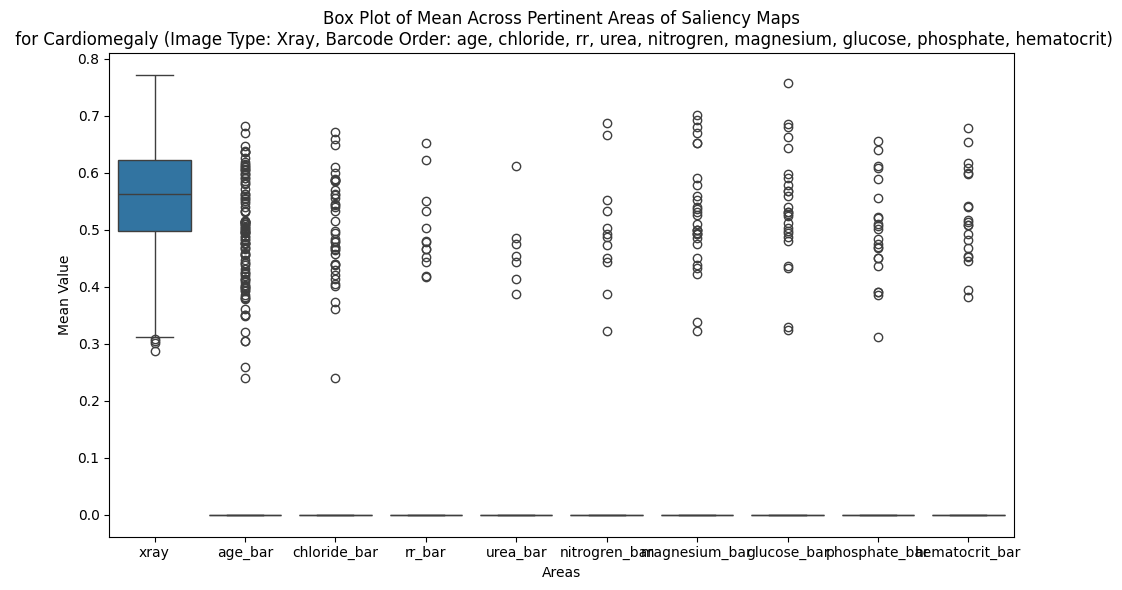

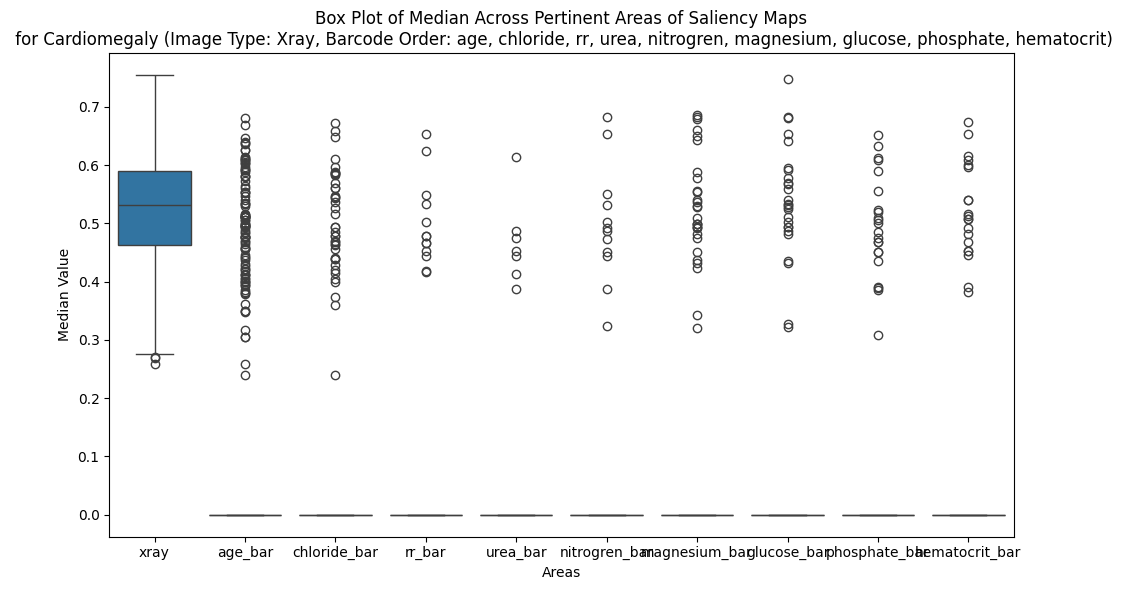

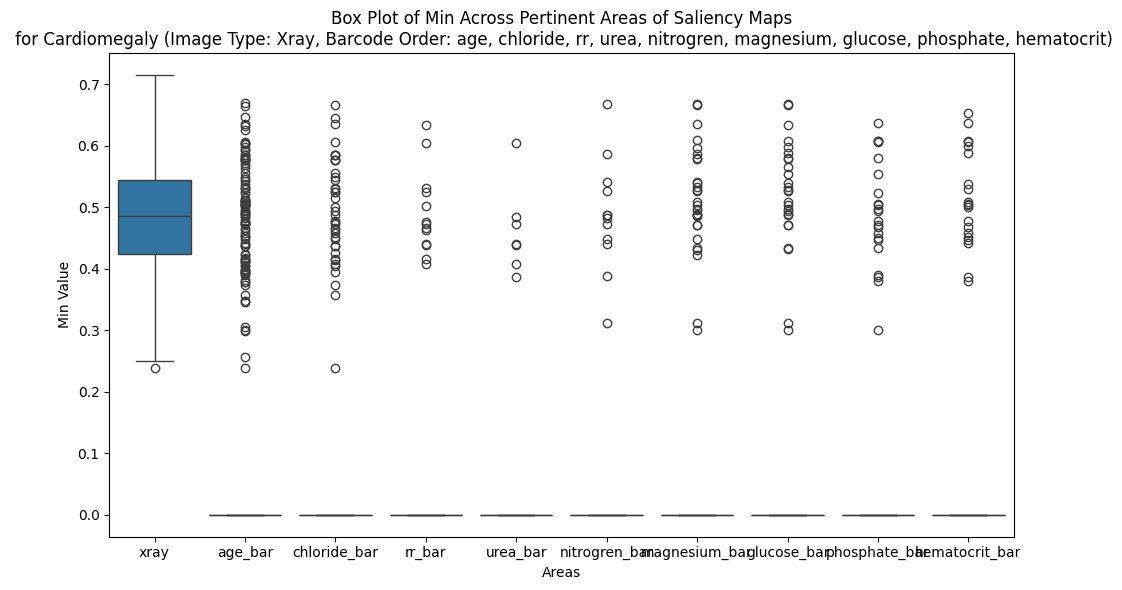

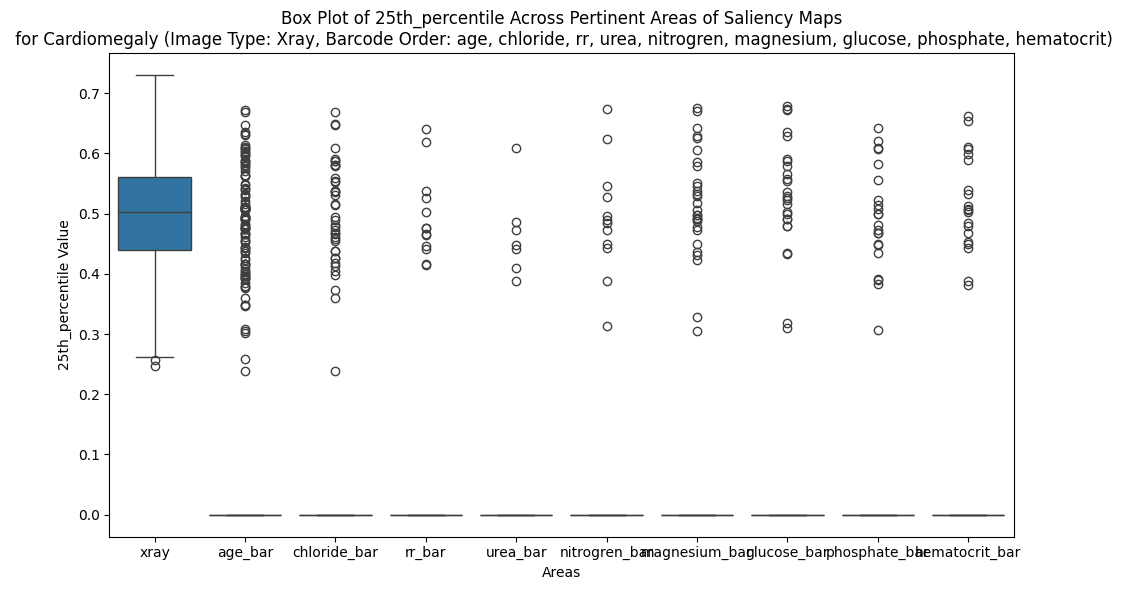

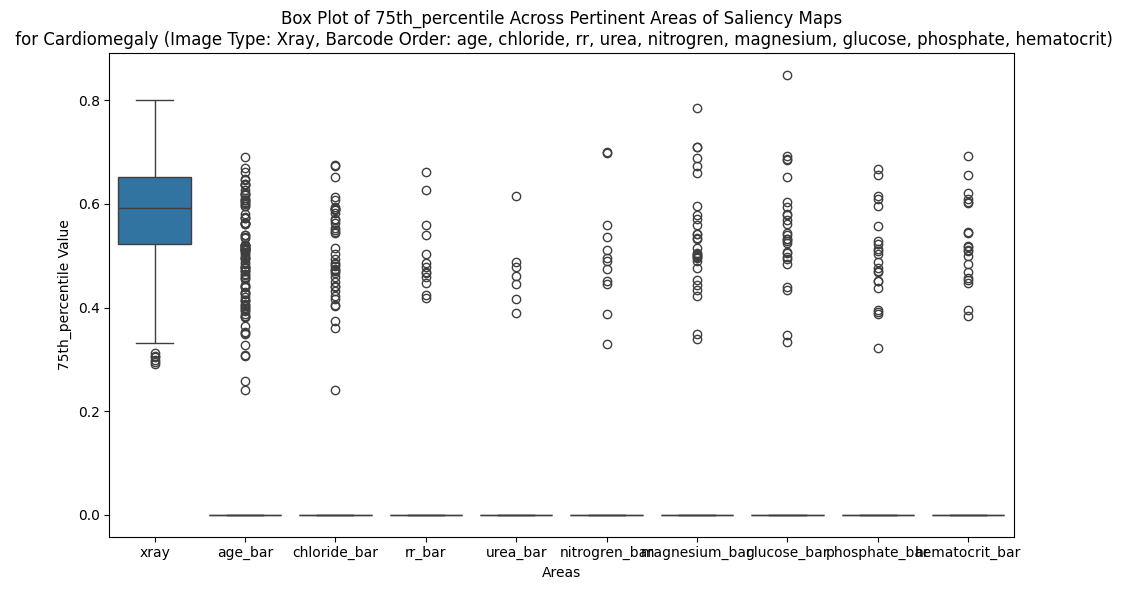

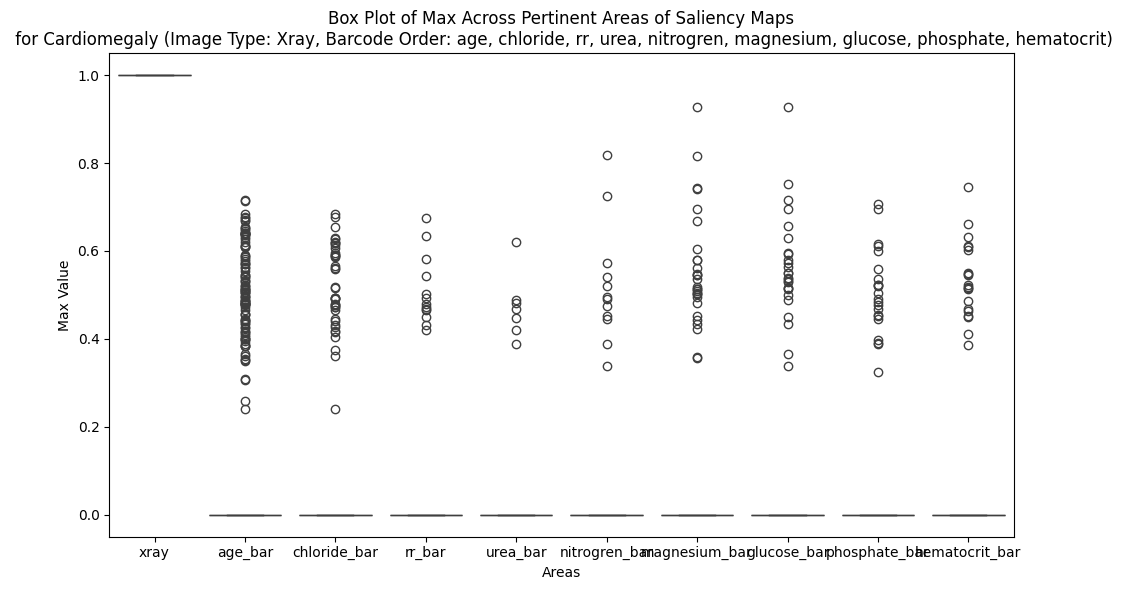

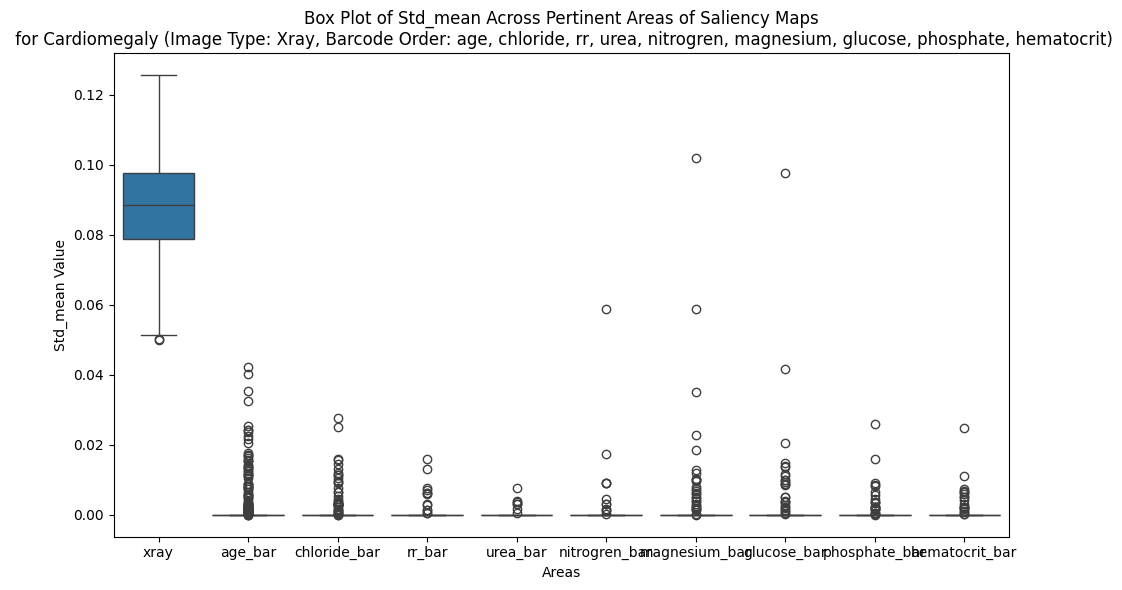

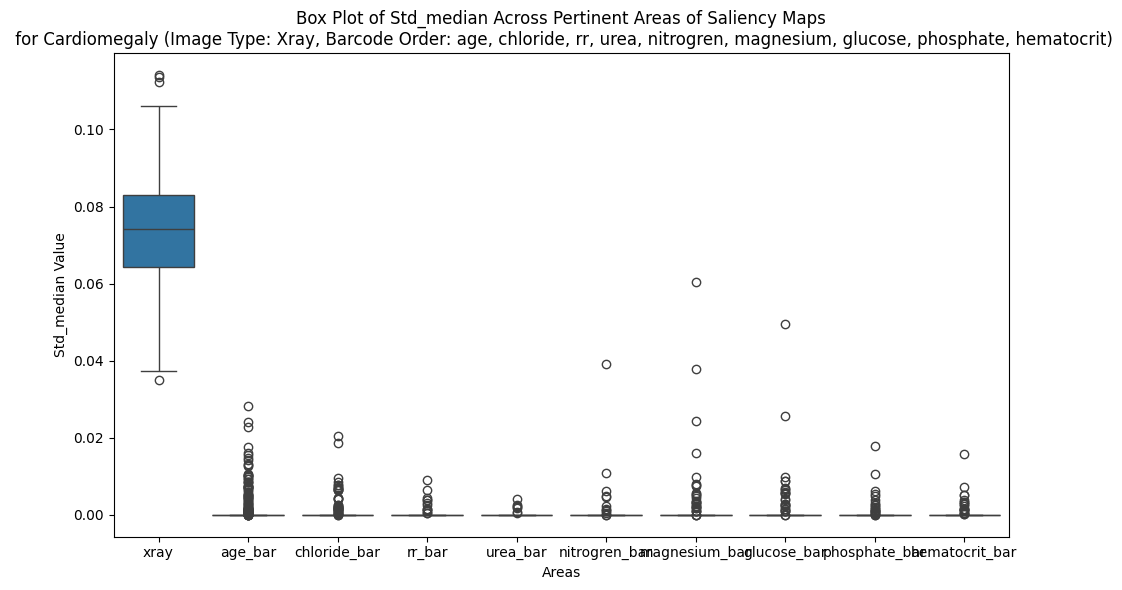

In [ ]:
image_type='xray'
mask_type = 'saliency'
label = 'Cardiomegaly'
order, suffix = get_barcode_order_info(order=None, no_bars=False, nan=False)
box_plot(image_type, suffix, mask_type, label, run_id=None, verbose=True)

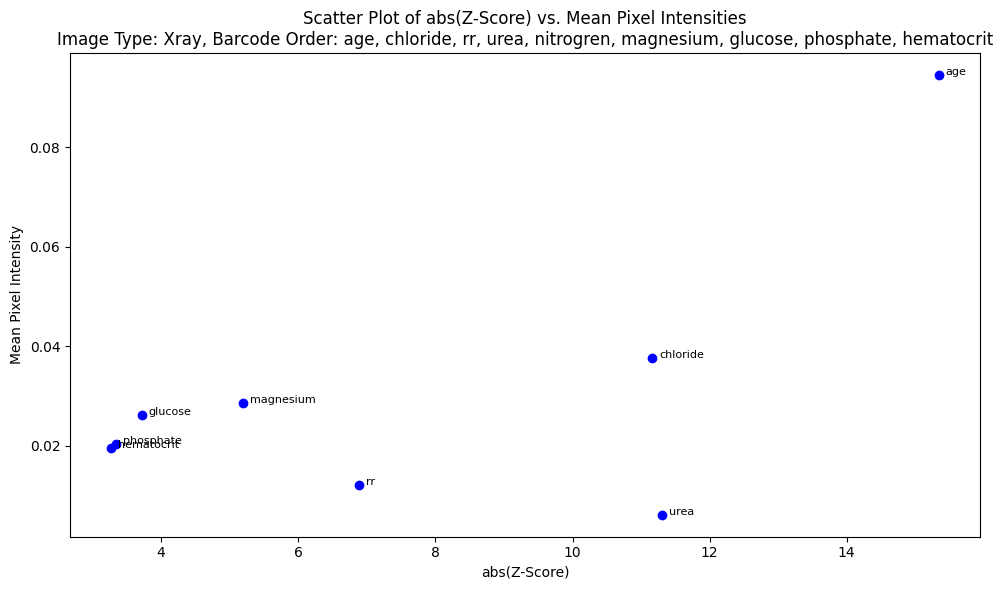

In [ ]:
means = {}; medians = {}
means[label], medians[label] = get_mean_median(image_type, suffix, mask_type, label)
scatter_plot(image_type, suffix, mask_type, means, verbose=True)

In [ ]:
perform_anova(image_type, suffix, mask_type, label)

Cardiomegaly Saliency P-Value: 0.0
Cardiomegaly Saliency F-Statistic: 1232.496013807281
There is a significant difference between the distributions.


In [6]:
probas = pd.read_csv(home_out_dir / 'cross-val/probas.csv', index_col=0)

In [7]:
probas.head(2)

,Cardiomegaly,target,xray_prob,noise_prob,blank_prob,lr_prob
0,0,0.0,0.904380,0.540764,0.355602,0.574107
1,1,1.0,0.999956,0.963636,0.825784,0.807873


<Axes: title={'center': 'Logistic Regression Probas vs Blank Bartender Probas\nfor MIMIC, predicting Cardiomegaly'}, xlabel='LR Probas', ylabel='Blank Bartender Probas'>

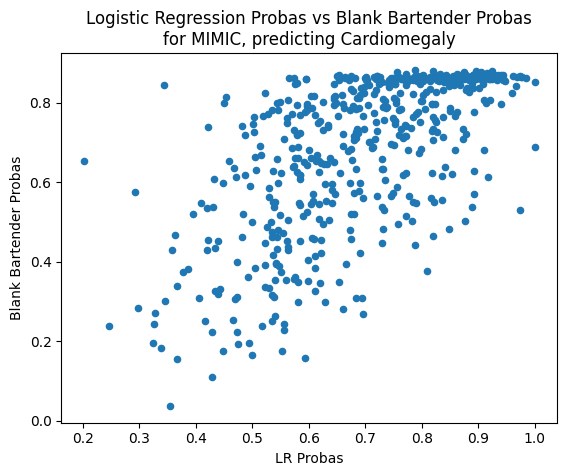

In [13]:
probas.plot.scatter("lr_prob", "blank_prob", title="Logistic Regression Probas vs Blank Bartender Probas\nfor MIMIC, predicting Cardiomegaly", xlabel="LR Probas", ylabel="Blank Bartender Probas")

<Axes: title={'center': 'Logistic Regression Probas vs Noise Bartender Probas\nfor MIMIC, predicting Cardiomegaly'}, xlabel='LR Probas', ylabel='Noise Bartender Probas'>

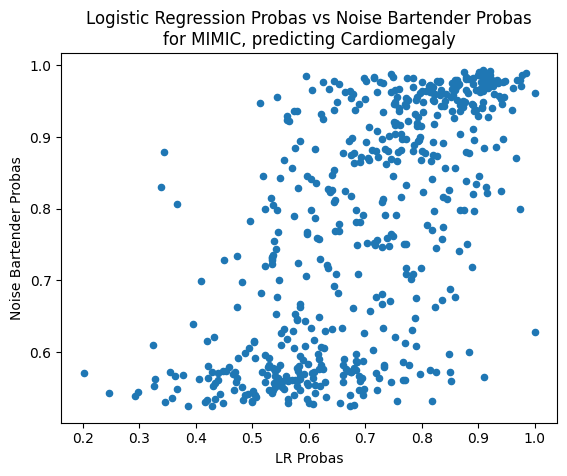

In [14]:
probas.plot.scatter("lr_prob", "noise_prob", title="Logistic Regression Probas vs Noise Bartender Probas\nfor MIMIC, predicting Cardiomegaly", xlabel="LR Probas", ylabel="Noise Bartender Probas")